In [1]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd

from Tarjet import *
from Phisicsparams import *
from utils import *
from MTMM import *
from tqdm import tqdm

from multiresglonet import GLOnet
from material_database import MatDatabase


In [2]:
from typing import TypeVarTuple


params = Params()
params.thickness_sup = 0.1
params.N_layers = 40

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.09
  params.n_max = 2.6
  params.M_discretion_n = 100
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en otro lado
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup =  15
params.numIter = 200
params.sigma = 0.035
params.batch_size = 100
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 16                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 256                                                                               # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 26                                                                              # Dimension de la Capa de entrada
params.lr = 0.05                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


In [3]:
params.condiciones = 2
physicsparams = PhysicsParams(params.condiciones, user_define=True)

n_interna = 1.2

physicsparams.n_bot_1 = n_interna
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 0
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "TE"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = n_interna
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.generate_physics_params()
# physicsparams.view_attributes()

tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()



In [4]:
if not params.user_define:
    params.matdatabase =  MatDatabase(params.materials)
    params.n_database = params.matdatabase.interp_wv(2 * math.pi/physicsparams.ks, params.materials, True)
    params.M_materials =  params.n_database.size(0)

In [5]:

tarjet.tarjets["tarjet_1"].view(-1)[190:] = 1

tarjet.tarjets["tarjet_2"].view(-1)[115:] = 1



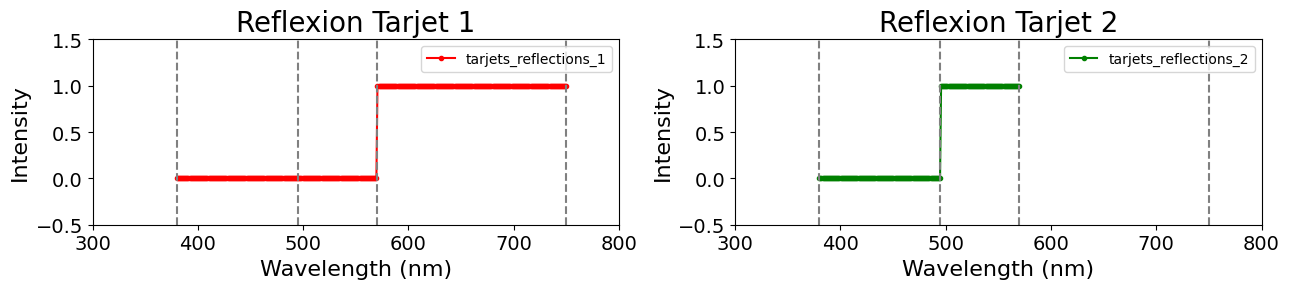

In [6]:
# Subplots para Reflexiones
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(2 * math.pi / physicsparams.k_1 * 1000, tarjet.tarjets["tarjet_1"].view(-1), ".-", color="red", label="tarjets_reflections_1")
        ax.set_title("Reflexion Tarjet 1", fontsize=20)
    elif i == 1:
        ax.plot(2 * math.pi / physicsparams.k_2 * 1000, tarjet.tarjets["tarjet_2"].view(-1), ".-", color="green", label="tarjets_reflections_2")
        ax.set_title("Reflexion Tarjet 2", fontsize=20)

    ax.set_xlabel("Wavelength (nm)", fontsize=16)
    ax.set_ylabel("Intensity", fontsize=16)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Agregar líneas verticales punteadas
    for line_pos in vertical_lines:
        ax.axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()


In [7]:

thicknesses_list = []
ref_idx_list = []

figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

histogram_dir = "Histogramas"
os.makedirs(histogram_dir, exist_ok=True)
    
Loss_dir =  "Losses"
if not os.path.exists(Loss_dir):
    os.makedirs(Loss_dir)

Error = []

xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]



n_interna = 1.2



for seed in range(50):                                                
  params.seed = seed
  params.sigma = np.random.uniform(0.025, 0.05)
  
  
  physicsparams.theta_1 = seed * 45 / 50
  print("Angulo theta_1 : " ,physicsparams.theta_1)

  physicsparams.n_bot_1 = n_interna
  physicsparams.n_top_1 = 1
  physicsparams.k_1 = 370
  physicsparams.k_values.append(physicsparams.k_1)
  physicsparams.lambda_min_1 = 380
  physicsparams.lambda_max_1 = 750
  physicsparams.pol_1 = "TE"
  
  physicsparams.n_bot_2 = 1
  physicsparams.n_top_2 = n_interna
  physicsparams.k_2 = 190
  physicsparams.k_values.append(physicsparams.k_2)
  physicsparams.theta_2 = 45
  physicsparams.lambda_min_2 = 380
  physicsparams.lambda_max_2 = 570
  physicsparams.pol_2 = "TE"
  
  physicsparams.generate_physics_params()

  print("Sigma: ", params.sigma)
  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  
  plt.figure(figsize = (20, 5))
  plt.subplot(131)
  plt.plot(glonet.loss_training)
  plt.ylabel('Loss', fontsize=18)
  plt.xlabel('Iterations', fontsize=18)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  
  plt.savefig(f"{Loss_dir}/Loss_seed_{seed}.png", bbox_inches='tight')
  plt.close()
  
  print(f"iteration{seed + 1 }")

  with torch.no_grad():
      params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
      params.theta_test = torch.linspace(0, math.pi/2.25, 50)
      (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
      # Optimizacion
      
      reflex = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)
      FoM_reflex_total = sum(torch.pow(reflex[f'reflexion_{i}'] - tarjet.tarjets[f'tarjet_{i}'], 2).mean(dim=[1, 2, 3]) for i in range(1, 3))
      _, indices = torch.sort(FoM_reflex_total)
      opt_idx = indices[0]
      Error.append(FoM_reflex_total[opt_idx])
      

      # Visualización del FoM total
      
      plt.figure(figsize=(10, 2))
      plt.subplot(131)
      plt.hist(FoM_reflex_total.cpu().detach().numpy(), alpha=0.5)
      plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.savefig(f"{histogram_dir}/histograma_seed_{seed}.png", bbox_inches='tight')
      plt.close()
      
      # Encontrar el índice óptimo

      optimal_thicknesses = thicknesses[opt_idx]
      optimal_ref_idx = ref_index[opt_idx]
      
      thicknesses_list.append(optimal_thicknesses.view(-1).cpu().numpy().tolist())
      ref_idx_list.append(optimal_ref_idx.view(-1).cpu().numpy().tolist())

          
 
  fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
  fig.subplots_adjust(wspace=0.4)
  
  # Definir optimal_reflections
  optimal_reflections = {}
  
  for i in range(1, 3):  # Solo 1 y 2
      reflex_key = f'reflexion_{i}'
      optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
      
      # Gráfico de reflexión óptima
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                    "-", color="violet", label="Optimal Reflexion")
  
      # Gráfico de reflexión de tarjeta
      tarjet_color = "red" if i == 1 else "green"
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    tarjet.tarjets[f"tarjet_{i}"].view(-1),
                    ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)
  
      axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
      axs[i-1].set_ylabel("Reflection", fontsize=16)
      axs[i-1].legend(fontsize=10)
      axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
      axs[i-1].tick_params(axis='both', which='major', labelsize=14)
      axs[i-1].set_xlim(xlim)
      axs[i-1].set_ylim(ylim)
  
      # Agregar líneas verticales punteadas para reflexiones
      for line_pos in vertical_lines:
          axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')
          
  fig.savefig(os.path.join(figures_dir, f"reflexion_seed_{seed}.png"))
  plt.close(fig)

with open('optimal_thicknesses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(thicknesses_list)

# Archivo CSV para los índices de refracción
with open('optimal_ref_idx.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ref_idx_list)




Angulo theta_1 :  0.0
Sigma:  0.034134764465462736


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


iteration1
Angulo theta_1 :  0.9
Sigma:  0.048932064579326


100%|██████████| 200/200 [06:56<00:00,  2.08s/it]


iteration2
Angulo theta_1 :  1.8
Sigma:  0.04791493573981867


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


iteration3
Angulo theta_1 :  2.7
Sigma:  0.04376307667043812


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


iteration4
Angulo theta_1 :  3.6
Sigma:  0.04338738196182142


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


iteration5
Angulo theta_1 :  4.5
Sigma:  0.039786478401871786


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


iteration6
Angulo theta_1 :  5.4
Sigma:  0.02538069846689544


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


iteration7
Angulo theta_1 :  6.3
Sigma:  0.025948096359979602


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


iteration8
Angulo theta_1 :  7.2
Sigma:  0.031262864087312096


100%|██████████| 200/200 [06:35<00:00,  1.98s/it]


iteration9
Angulo theta_1 :  8.1
Sigma:  0.037546572284987506


100%|██████████| 200/200 [06:37<00:00,  1.99s/it]


iteration10
Angulo theta_1 :  9.0
Sigma:  0.04354810172154795


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


iteration11
Angulo theta_1 :  9.9
Sigma:  0.031644412067561654


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


iteration12
Angulo theta_1 :  10.8
Sigma:  0.03851558992622756


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


iteration13
Angulo theta_1 :  11.7
Sigma:  0.03539423169262141


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


iteration14
Angulo theta_1 :  12.6
Sigma:  0.04528683752012775


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


iteration15
Angulo theta_1 :  13.5
Sigma:  0.03998532443647257


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


iteration16
Angulo theta_1 :  14.4
Sigma:  0.03666937472322472


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


iteration17
Angulo theta_1 :  15.3
Sigma:  0.03443805087009888


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


iteration18
Angulo theta_1 :  16.2
Sigma:  0.02938380310633474


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


iteration19
Angulo theta_1 :  17.1
Sigma:  0.04372559904789208


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


iteration20
Angulo theta_1 :  18.0
Sigma:  0.04969476030872745


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


iteration21
Angulo theta_1 :  18.9
Sigma:  0.02787375865765107


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


iteration22
Angulo theta_1 :  19.8
Sigma:  0.039681995824785495


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


iteration23
Angulo theta_1 :  20.7
Sigma:  0.042440514577419264


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


iteration24
Angulo theta_1 :  21.6
Sigma:  0.038003447742068694


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


iteration25
Angulo theta_1 :  22.5
Sigma:  0.042825143140604795


100%|██████████| 200/200 [06:35<00:00,  1.98s/it]


iteration26
Angulo theta_1 :  23.4
Sigma:  0.03682728181838796


100%|██████████| 200/200 [06:37<00:00,  1.99s/it]


iteration27
Angulo theta_1 :  24.3
Sigma:  0.0486314846730646


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


iteration28
Angulo theta_1 :  25.2
Sigma:  0.025559860644119935


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


iteration29
Angulo theta_1 :  26.1
Sigma:  0.02762307935945194


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


iteration30
Angulo theta_1 :  27.0
Sigma:  0.037481547373072015


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


iteration31
Angulo theta_1 :  27.9
Sigma:  0.04466757144472451


100%|██████████| 200/200 [06:36<00:00,  1.98s/it]


iteration32
Angulo theta_1 :  28.8
Sigma:  0.03935172380381423


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


iteration33
Angulo theta_1 :  29.7
Sigma:  0.04617785426099179


100%|██████████| 200/200 [06:37<00:00,  1.99s/it]


iteration34
Angulo theta_1 :  30.6
Sigma:  0.0308498354182632


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


iteration35
Angulo theta_1 :  31.5
Sigma:  0.04598001579290713


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


iteration36
Angulo theta_1 :  32.4
Sigma:  0.044195986020520446


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


iteration37
Angulo theta_1 :  33.3
Sigma:  0.03766754520979823


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


iteration38
Angulo theta_1 :  34.2
Sigma:  0.04116689430592289


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


iteration39
Angulo theta_1 :  35.1
Sigma:  0.04881094426366261


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


iteration40
Angulo theta_1 :  36.0
Sigma:  0.03327314456548544


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


iteration41
Angulo theta_1 :  36.9
Sigma:  0.044951081335497


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


iteration42
Angulo theta_1 :  37.8
Sigma:  0.044767236657313095


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


iteration43
Angulo theta_1 :  38.7
Sigma:  0.0351789094905926


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


iteration44
Angulo theta_1 :  39.6
Sigma:  0.026890154179091633


100%|██████████| 200/200 [8:50:34<00:00, 159.17s/it]     


iteration45
Angulo theta_1 :  40.5
Sigma:  0.040620286537942474


100%|██████████| 200/200 [06:04<00:00,  1.82s/it]


iteration46
Angulo theta_1 :  41.4
Sigma:  0.03581327908708791


100%|██████████| 200/200 [05:58<00:00,  1.79s/it]


iteration47
Angulo theta_1 :  42.3
Sigma:  0.030869852785915152


100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


iteration48
Angulo theta_1 :  43.2
Sigma:  0.035123106016029595


100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


iteration49
Angulo theta_1 :  44.1
Sigma:  0.04662478245592927


100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


iteration50


In [12]:
Error = [0.1112,0.0322,0.1035,0.1576,0.0984,0.0885,0.1421,0.1173,0.1112,0.1335,0.0921,0.1323,0.1208,0.0933,0.0624,0.1334,0.1324,0.1332,0.1269,0.1178,0.1272,0.1458,0.1239,0.1175,0.1502,0.2193,0.1448,0.1785,0.1534,0.1632,0.1896,0.2881,0.2957,0.2643,0.2487,0.2742,0.2664,0.2927,0.2376,0.3291,0.3014,0.3370,0.2762,0.2527,0.3691,0.3525,0.3661,0.3165,0.3242,0.3465,]
Error = np.array(Error)

In [13]:
Angles =  np.linspace(0 , 45 , 50) 

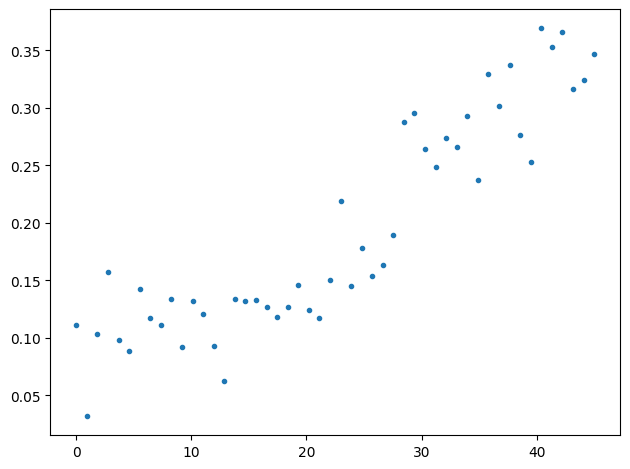

In [15]:
plt.plot(Angles , Error, ".")

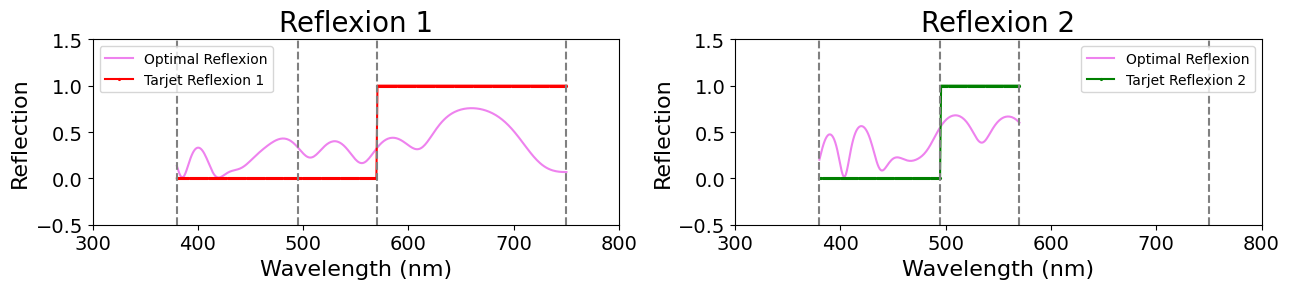

Espesores: tensor([0.0992, 0.1104, 0.1289, 0.1207, 0.0979, 0.0833, 0.0679, 0.1032, 0.0754,
        0.0453, 0.0440, 0.0413, 0.0835, 0.0592, 0.0855, 0.0350, 0.0551, 0.0564,
        0.0649, 0.1078, 0.1238, 0.0888, 0.0673, 0.0722, 0.0759])
Índices de refracción: tensor([2.2943, 2.3951, 1.4694, 1.7354, 1.9702, 1.7653, 1.2873, 1.6529, 2.5393,
        1.9702, 1.6287, 1.2645, 2.2054, 1.2418, 1.1128, 1.5714, 2.2358, 1.0900,
        2.0349, 2.4710, 1.5908, 1.4522, 1.1811, 1.4315, 2.2359],
       dtype=torch.float64)


In [ ]:
# Definir xlim, ylim y vertical_lines
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

# Subplots para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)

# Definir optimal_reflections
optimal_reflections = {}

for i in range(1, 3):  # Solo 1 y 2
    reflex_key = f'reflexion_{i}'
    optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
    
    # Gráfico de reflexión óptima
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                  "-", color="violet", label="Optimal Reflexion")

    # Gráfico de reflexión de tarjeta
    tarjet_color = "red" if i == 1 else "green"
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  tarjet.tarjets[f"tarjet_{i}"].view(-1),
                  ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)

    axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
    axs[i-1].set_ylabel("Reflection", fontsize=16)
    axs[i-1].legend(fontsize=10)
    axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
    axs[i-1].tick_params(axis='both', which='major', labelsize=14)
    axs[i-1].set_xlim(xlim)
    axs[i-1].set_ylim(ylim)

    # Agregar líneas verticales punteadas para reflexiones
    for line_pos in vertical_lines:
        axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()

print("Espesores:", optimal_thicknesses.view(-1))
print("Índices de refracción:", optimal_ref_idx.view(-1))


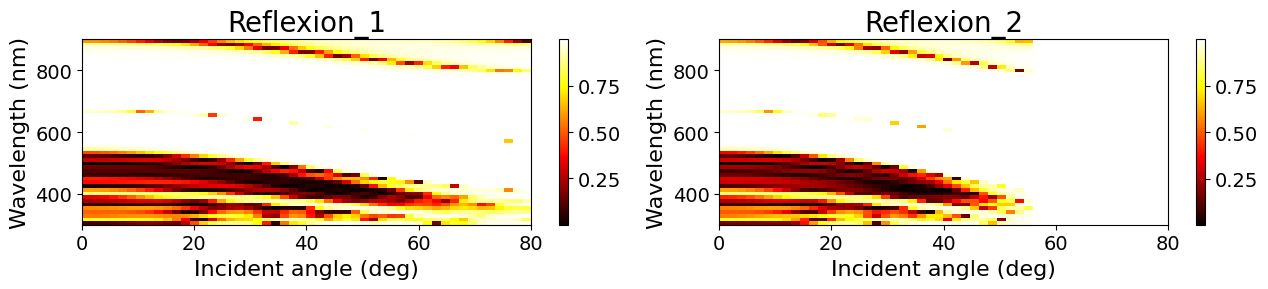

In [ ]:
(thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
r = []
params.k_test = 2 * math.pi / torch.linspace(0.3, 0.9, 50)
params.theta_test = torch.linspace(0, math.pi/2.25, 50)

for i in range(2):  # Solo 2 iteraciones para reflexion_1 y reflexion_2
    r_  = TMM_solver(thicknesses, 
                        ref_index, 
                        getattr(physicsparams, f'n_top_{i + 1}'), 
                        getattr(physicsparams, f'n_bot_{i + 1}'),
                        params.k_test,
                        params.theta_test)
    r.append(r_)

_ ,  index = torch.sort(FoM_reflex_total)
opt_inx =  index[0]

# Gráficos para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)
for i in range(2):  # Solo 2 gráficos para reflexion_1 y reflexion_2
    im1 = axs[i].imshow(r[i][opt_inx, : , 0, :].detach().cpu().numpy(), origin='lower', aspect='auto', cmap='hot', extent=[0, 80, 300, 900])
    cbar1 = fig.colorbar(im1, ax=axs[i])
    cbar1.ax.tick_params(labelsize=14)
    axs[i].set_title(f'Reflexion_{i + 1}', fontsize=20)  # Reflexion_{1} y Reflexion_{2}
    axs[i].set_xlabel('Incident angle (deg)', fontsize=16)
    axs[i].set_ylabel('Wavelength (nm)', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

plt.show()
